In [18]:
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, precision_score, recall_score,
    confusion_matrix, matthews_corrcoef, average_precision_score, roc_curve, precision_recall_curve
)

import matplotlib.pyplot as plt

def calculate_metrics(all_labels, all_predictions, all_probs=None):
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    prec = precision_score(all_labels, all_predictions)
    rec = recall_score(all_labels, all_predictions)
    cm = confusion_matrix(all_labels, all_predictions)
    mcc = matthews_corrcoef(all_labels, all_predictions)

    tn, fp, fn, tp = confusion_matrix(all_labels, all_predictions).ravel()
    specificity = tn / (tn + fp)
    
    # For AUC and AUPRC, use probabilities if provided
    auc = roc_auc_score(all_labels, all_probs) if all_probs is not None else None
    auprc = average_precision_score(all_labels, all_probs) if all_probs is not None else None

    # plot confusion matrix with numbers
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['0', '1'])
    ax.set_yticklabels(['0', '1'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
    plt.title('Confusion Matrix')
    plt.show()

    # plot auc curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    # plot precision-recall curve
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}" if auc is not None else "AUC: N/A")
    print(f"AUPRC: {auprc:.4f}" if auprc is not None else "AUPRC: N/A")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"Confusion Matrix: \n{cm}")

In [8]:
# Dataset class for Breast Cancer data
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np

class BreastCancerDataset(Dataset):
    def __init__(self, clinical_path, cna_path, mrna_path, labels_path):
        # Load data
        self.clinical_data = pd.read_csv(clinical_path)
        self.cna_data = pd.read_csv(cna_path, index_col=0)  # Load CNA with index as PATIENT_ID
        self.mrna_data = pd.read_csv(mrna_path, index_col=0)  # Load mRNA with index as PATIENT_ID
        self.labels = pd.read_csv(labels_path)
        
        # Drop the PATIENT_ID column from clinical data if it exists
        if "PATIENT_ID" in self.clinical_data.columns:
            self.clinical_data = self.clinical_data.drop(columns=["PATIENT_ID"])
        
        # Reset the index for CNA and mRNA data to avoid including PATIENT_ID
        self.cna_data = self.cna_data.reset_index(drop=True)
        self.mrna_data = self.mrna_data.reset_index(drop=True)
        
        # Convert data to numeric arrays
        self.clinical_data = pd.get_dummies(self.clinical_data, drop_first=True).to_numpy(dtype=np.float32)
        self.cna_data = self.cna_data.to_numpy(dtype=np.float32)
        self.mrna_data = self.mrna_data.to_numpy(dtype=np.float32)

        # Remove columns with NaNs in CNA and mRNA data
        cna_nan_columns = np.isnan(self.cna_data).any(axis=0)
        self.cna_data = self.cna_data[:, ~cna_nan_columns]
        mrna_nan_columns = np.isnan(self.mrna_data).any(axis=0)
        self.mrna_data = self.mrna_data[:, ~mrna_nan_columns]
        
        # Ensure labels are aligned and converted to numeric arrays
        self.labels = self.labels["SURVIVAL_BINARY"].to_numpy(dtype=np.float32)  # Use only the label column

        print("Clinical data shape:", self.clinical_data.shape)
        print("CNA data shape:", self.cna_data.shape)
        print("mRNA data shape:", self.mrna_data.shape)
        print("Labels shape:", self.labels.shape)       

    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        clinical = torch.tensor(self.clinical_data[idx], dtype=torch.float32)
        cna = torch.tensor(self.cna_data[idx], dtype=torch.float32)
        mrna = torch.tensor(self.mrna_data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return clinical, cna, mrna, label

# Load the dataset into a DataLoader
from torch.utils.data import DataLoader

# Paths to preprocessed files
clinical_path = "brca_metabric/dataset/clinical_data.csv"
cna_path = "brca_metabric/dataset/cna_data.csv"
mrna_path = "brca_metabric/dataset/mrna_zscores.csv"
labels_path = "brca_metabric/dataset/labels.csv"

# Create dataset and dataloaders
dataset = BreastCancerDataset(clinical_path, cna_path, mrna_path, labels_path)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Test the DataLoader
for clinical, cna, mrna, label in train_loader:
    print(f"Clinical shape: {clinical.shape}")
    print(f"CNA shape: {cna.shape}")
    print(f"mRNA shape: {mrna.shape}")
    print(f"Labels shape: {label.shape}")
    break



Clinical data shape: (1980, 196)
CNA data shape: (1980, 22079)
mRNA data shape: (1980, 20592)
Labels shape: (1980,)
Clinical shape: torch.Size([32, 196])
CNA shape: torch.Size([32, 22079])
mRNA shape: torch.Size([32, 20592])
Labels shape: torch.Size([32])


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultimodalModel(nn.Module):
    def __init__(self, clinical_dim, cna_dim, mrna_dim, hidden_dim=128, num_classes=2):
        super(MultimodalModel, self).__init__()
        
        # Clinical branch
        self.clinical_fc = nn.Sequential(
            nn.Linear(clinical_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # CNA branch
        self.cna_fc = nn.Sequential(
            nn.Linear(cna_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # mRNA Transformer branch
        self.mrna_embedding = nn.Linear(mrna_dim, hidden_dim)
        self.mrna_transformer = nn.Transformer(hidden_dim, nhead=8, num_encoder_layers=2)
        
        # Fully connected layers to combine all branches
        self.fc_combined = nn.Sequential(
            nn.Linear(hidden_dim * 3, 128),  # Concatenate outputs from the three branches
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)  # Final output layer
        )
    
    def forward(self, clinical, cna, mrna):
        # Clinical branch
        clinical_out = self.clinical_fc(clinical)
        
        # CNA branch
        cna_out = self.cna_fc(cna)
        
        # mRNA branch
        mrna_embed = self.mrna_embedding(mrna).unsqueeze(1)  # Add sequence length dim
        mrna_out = self.mrna_transformer(mrna_embed, mrna_embed).squeeze(1)  # Remove seq dim
        
        # Combine all branches
        combined = torch.cat((clinical_out, cna_out, mrna_out), dim=1)
        output = self.fc_combined(combined)
        return output


In [10]:
# Training loop
def train_multimodal(model, dataloader, optimizer, criterion, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for clinical, cna, mrna, labels in dataloader:
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(clinical, cna, mrna)
            loss = criterion(outputs, labels.long())  # Ensure labels are long for CrossEntropyLoss
            total_loss += loss.item()
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
        
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(dataloader):.4f}")

# Evaluation loop
def evaluate_multimodal(model, dataloader, criterion):
    model.eval()
    all_labels, all_predictions, all_probs = [], [], []
    total_loss = 0
    
    with torch.no_grad():
        for clinical, cna, mrna, labels in dataloader:
            # Forward pass
            outputs = model(clinical, cna, mrna)
            loss = criterion(outputs, labels.long())
            total_loss += loss.item()
            
            # Predictions and probabilities
            probs = torch.softmax(outputs, dim=1)[:, 1]
            _, predictions = torch.max(outputs, dim=1)
            
            # Collect metrics
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    print(f"Test Loss: {total_loss / len(dataloader):.4f}")
    calculate_metrics(all_labels, all_predictions, all_probs)


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1, Loss: 1.1637
Epoch 2, Loss: 0.5961
Epoch 3, Loss: 0.5525
Epoch 4, Loss: 0.5357
Epoch 5, Loss: 0.5150
Epoch 6, Loss: 0.4831
Epoch 7, Loss: 0.4625
Epoch 8, Loss: 0.4373
Epoch 9, Loss: 0.4068
Epoch 10, Loss: 0.3550
Test Loss: 0.8160


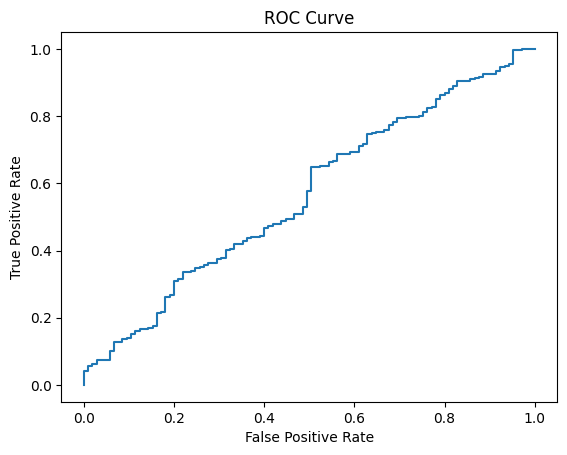

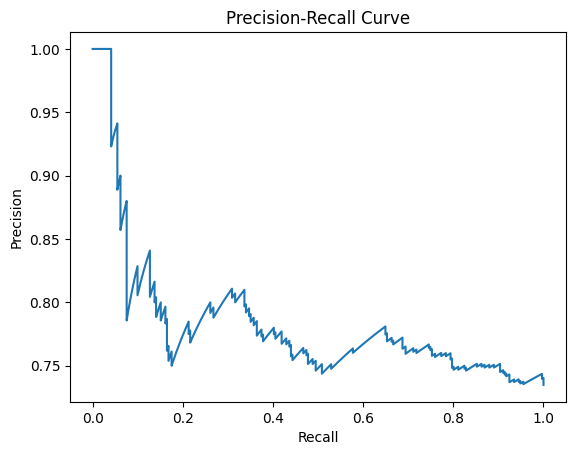

Accuracy: 0.6591
F1 Score: 0.7776
AUC: 0.5638
AUPRC: 0.7838
Precision: 0.7468
Recall: 0.8110
Specificity: 0.2381
MCC: 0.0540
Confusion Matrix: 
[[ 25  80]
 [ 55 236]]


In [ ]:
# Model parameters
clinical_dim = dataset.clinical_data.shape[1]
cna_dim = dataset.cna_data.shape[1]
mrna_dim = dataset.mrna_data.shape[1]

# Initialize the model
multimodal_model = MultimodalModel(clinical_dim, cna_dim, mrna_dim)

# Optimizer and loss
optimizer = torch.optim.Adam(multimodal_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train
train_multimodal(multimodal_model, train_loader, optimizer, criterion, epochs=10)


Test Loss: 0.8160


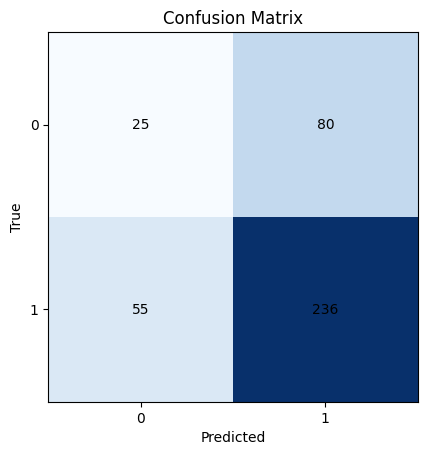

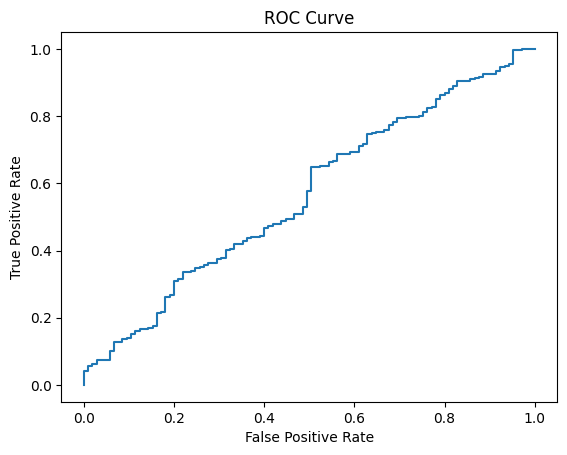

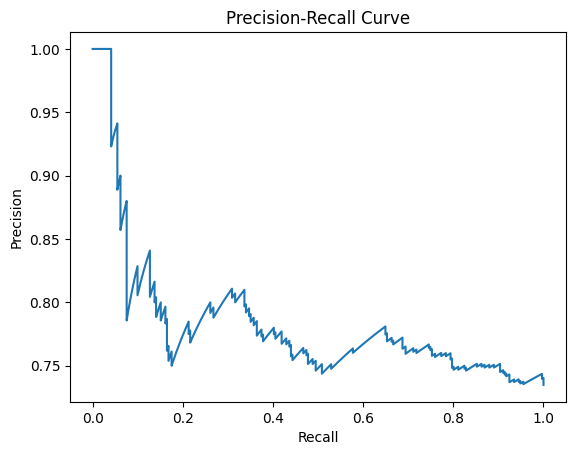

Accuracy: 0.6591
F1 Score: 0.7776
AUC: 0.5638
AUPRC: 0.7838
Precision: 0.7468
Recall: 0.8110
Specificity: 0.2381
MCC: 0.0540
Confusion Matrix: 
[[ 25  80]
 [ 55 236]]


In [19]:
# Evaluate
evaluate_multimodal(multimodal_model, test_loader, criterion)